In [27]:
import os
from brian2 import *
import numpy as np
import math
import time
import random as pyrandom


def poisson_input(active, N_input, r, time_input, t1, t2):
    "function to built a poisson input"
    "with no zero firing rates"

    start_scope()
    N = 1000
    P = PoissonGroup(N, 0 * Hz)
    S = SpikeMonitor(P)

    run(t1)

    P.rates = r
    run(time_input)

    P.rates = 0 * Hz
    run(t2)

    s = []
    remove = []
    for i in range(N):
        s.append(S.count[i])
        if S.count[i] == 0:
            remove.append(i)

    pos = [x for x in range(N) if x not in remove]
    pos = pyrandom.sample(pos, len(active))

    C = []
    spike_trains = S.spike_trains()
    for ii in range(len(pos)):
        D = list(spike_trains[pos[ii]])
        D = [(active[ii], x) for x in D]
        C += D
    C = sorted(C, key=lambda x: x[1])
    start_scope()
    return C

def create_connections(N_source, N_target, conn_probability):
    '''
    N_source: source neuron number
    N_target: target neuron number
    conn_probability: connect probability
    return: i_st: a list of source_index
            j_st: a list of target_index
    example:
    [i_st, j_st] = create_connections(4, 4, 0.25)
    print(i_st)
    print(j_st)
    '''
    conn_p = conn_probability
    list_st0 = []
    list_st1 = []
    for i in range(N_source):
        n = N_target * conn_p
        list_st_temp = sorted(pyrandom.sample(range(N_target), int(n)))
        list_st0 += [i] * int(n)
        list_st1 += list_st_temp
    i_st = list_st0
    j_st = list_st1
    return i_st, j_st

def DG_with_EC_GC_MC_BC_HIPP(os_path, Trial_str, overlap_str):
    Trial = Trial_str
    overlap = overlap_str
    # General Parameters
    scale_fac = 4
    N_input = 100 * scale_fac
    N_granule = 500 * scale_fac
    N_basket = 25 * scale_fac
    N_mossy = 20 * scale_fac
    N_hipp = 10 * scale_fac
#     N_sgc = 150 * scale_fac
#     N_abDGC = 25 * scale_fac
    d_input = 0.10  # active input density

    # Active pattern of neurons
    os.chdir(os_path + '\input_pattern')
    # active = sorted(pyrandom.sample(range(N_input), int(d_input * N_input)))
    # np.save('active_pattern_Trial_with_four_neuron' + str(Trial) + '.npy', active)
    # active = np.load('active_pattern_Trial_with_four_neuron0.npy')
    # active = np.load('active_pattern_Trial_with_four_neuron' + str(Trial) + '_' + str(overlap) + '.npy')  
    # inactive = [x for x in range(N_input) if x not in active]
    active = np.load('active_pattern_Trial_with_abdgc0_'+str(overlap)+'.npy')
    inactive = [x for x in range(N_input) if x not in active]

    # ######################## CONNECTIVITY PARAMETERS #########################

    # General parameters
    E_nmda = 0 * mV  # NMDA reversal potential
    E_ampa = 0 * mV  # AMPA reversal potential
    E_gaba = -86 * mV  # GABA reversal potential
    gamma = 0.072 * mV ** -1  # Mg Concentration factor
    alpha_nmda = 0.5 * ms ** -1  # NMDA scale factor
    alpha_ampa = 1 * ms ** -1  # AMPA scale factor
    alpha_gaba = 1 * ms ** -1  # GABA scale factor

    # Original connection

    # EC CELLS ---> GRANULE CELLS
    g_ampa_eg = 0.8066 * nS * 1
    g_nmda_eg = 1.0800 * g_ampa_eg

    # EC CELLS ---> HIPP CELLS
    g_ampa_eh = 0.24 * nS * 1
    g_nmda_eh = 1.15 * g_ampa_eh

    # SOURCE: GRANULE CELLS
    # GRANULE CELLS ---> BASKET CELLS
    g_ampa_gb = 0.21 * nS * 1.5
    g_nmda_gb = 1.50 * g_ampa_gb

    # GRANULE CELLS ---> MOSSY CELLS
    g_ampa_gm = 0.50 * nS * 1.2
    g_nmda_gm = 1.05 * g_ampa_gm * 1.2

    # SOURCE: MOSSY CELLS
    # MOSSY CELLS ---> GRANULE CELLS
    g_ampa_mg = 0.1066 * nS * 1
    g_nmda_mg = 1.0800 * g_ampa_mg

    # MOSSY CELLS ---> BASKET CELLS
    g_ampa_mb = 0.35 * nS * 1
    g_nmda_mb = 1.1 * g_ampa_mb

    # SOURCE: BASKET CELLS
    # BASKET CELLS ---> GRANULE CELLS
    g_gaba_bg = 14.0 * nS * 1.1

    # SOURCE: HIPP CELLS
    # HIPP CELLS ---> GRANULE CELLS
    g_gaba_hg = 0.12 * nS * 1

#     print('Initializing parameters over ...')

    # =====================================================================================================
    # ******************************************* C O N N E C T I O N *************************************
    # =====================================================================================================
    os.chdir(os_path + '\connections')
    # ========================================connectivity from EC to Granule p = 0.2 =====================
    i_eg = np.load('syn_i_eg_0.2.npy')
    j_eg = np.load('syn_j_eg_0.2.npy')
    # ========================================connectivity from EC to HIPP p = 0.2 ========================
    i_eh = np.load('syn_i_eh_0.2.npy')
    j_eh = np.load('syn_j_eh_0.2.npy')
    # ========================================connectivity hipp to granule p = 0.2 ========================
    i_hg = np.load('syn_i_hg_0.2.npy')
    j_hg = np.load('syn_j_hg_0.2.npy')
    # ========================================connectivity from Granule to Mossy p = 0.2===================
    i_gm = np.load('syn_i_gm_0.2.npy')
    j_gm = np.load('syn_j_gm_0.2.npy')
    # ========================================connectivity from mossy to granule p = 0.2===================
    i_mg = np.load('syn_i_mg_0.2.npy')
    j_mg = np.load('syn_j_mg_0.2.npy')
    # ========================================connectivity Granule to Basket (all to one)==================
    i_gb = np.load('syn_i_gb.npy')
    j_gb = np.load('syn_j_gb.npy')
    # ========================================connectivity basket to granule (one to all)==================
    i_bg = np.load('syn_i_bg.npy')
    j_bg = np.load('syn_j_bg.npy')
    # ========================================connectivity Mossy to Basket p = 1.0=========================
    # p = 1.0

    start_scope()  # 用在jupyter notebook中,保证在这个函数之前定义的对象不纳入下一次的模拟中

    # =====================================================================================================
    # ******************************************* M O D E L ***********************************************
    # =====================================================================================================
    # =================================== INPUT CELLS(ENTORHINAL CORTEX) ==================================
    rate = 40 * Hz
    simtime = 500 * ms
    t1 = 300 * ms
    t2 = 10 * ms
    spiketimes = poisson_input(active, N_input, rate, simtime, t1, t2)
    index, times = zip(*spiketimes)
    Input_ec = SpikeGeneratorGroup(N_input, index, times)
    # Input_ec = PoissonGroup(N_input, 40*Hz)
    # =======================================================================================================

    # =================================== GRANULE CELLS =====================================================
    # Parameters
    gl_g = 0.203 * nS * 1.3  # leakage conductance
    El_g = -87.0 * mV  # reversal-resting potential
    Cm_g = 6.7824 * pF  # membrane capacitance
    v_reset_g = -74 * mV  # reset potential
    tauw_g = 45 * ms  # adaptation time constant
    a_g = 2.0 * nS  # adaptation coupling parameter
    b_g = 0.0450 * nA  # spike triggered adaptation
    v_th_g = -56 * mV  # threshold potential

    gamma_g = 0.04 * mV ** -1  # the steepness of Mg sensitivity of Mg unblock
    Mg = 2.0  # [mM]--mili Molar - the extracellular Magnesium concentration
    eta = 0.2  # [mM**-1] -1- mili Molar **(-1) - Magnesium sensitivity of unblock

    t_nmda_decay_g = 50.0 * ms  # NMDA decay time constant
    t_nmda_rise_g = 0.33 * ms  # NMDA rise time constant
    t_ampa_decay_g = 2.5 * ms  # AMPA decay time constant
    t_ampa_rise_g = 0.1 * ms  # AMPA rise time constant
    t_gaba_decay_g = 6.8 * ms  # GABA decay time constant
    t_gaba_rise_g = 0.9 * ms  # GABA rise time constant
    alpha_nmda = 2.0 * ms ** -1
    alpha_ampa = 1.0 * ms ** -1
    alpha_gaba = 1.0 * ms ** -1

    # NOISE PARAMETERS
    g_ampa_gn = 0.008 * nS
    g_nmda_gn = 0.008 * nS

    gc_eqs = '''
    dv_g/dt = (gl_g*(El_g-v_g)+I_g-w_g)/Cm_g                                                                     : volt
    dw_g/dt = (a_g*(v_g-El_g)-w_g)/tauw_g                                                                        : amp
    I_g = I_inj + I_gaba_bg + I_nmda_eg + I_ampa_eg + I_nmda_mg + I_ampa_mg + I_gaba_hg + I_nmda_gn + I_ampa_gn  : amp
    #I_g = I_inj + I_nmda_eg + I_ampa_eg + I_gaba_bg +I_gaba_hg + I_nmda_gn + I_ampa_gn                          : amp
    I_gaba_bg = -g_gaba_bg * (v_g - E_gaba) * s_gaba_bg                                                          : amp
    s_gaba_bg                                                                                                    : 1
    I_nmda_mg = -g_nmda_mg*(v_g - E_nmda)*s_nmda_mg*(1.0/(1 + eta*Mg*exp(-gamma_g*v_g)))                         : amp
    I_ampa_mg = -g_ampa_mg*(v_g - E_ampa)*s_ampa_mg                                                              : amp
    s_nmda_mg                                                                                                    : 1
    s_ampa_mg                                                                                                    : 1
    I_nmda_eg = -g_nmda_eg*(v_g - E_nmda)*s_nmda_eg*(1.0/(1 + eta*Mg*exp(-gamma_g*v_g)))                         : amp
    I_ampa_eg = -g_ampa_eg*(v_g - E_ampa)*s_ampa_eg                                                              : amp
    s_nmda_eg                                                                                                    : 1
    s_ampa_eg                                                                                                    : 1
    I_gaba_hg = -g_gaba_hg * (v_g - E_gaba) * s_gaba_hg                                                          : amp
    s_gaba_hg                                                                                                    : 1
    I_nmda_gn = -g_nmda_gn*(v_g - E_nmda)*s_nmda_gn*(1.0/(1 + eta*Mg*exp(-gamma_g*v_g)))                         : amp
    I_ampa_gn = -g_ampa_gn*(v_g - E_ampa)*s_ampa_gn                                                              : amp
    s_nmda_gn                                                                                                    : 1
    s_ampa_gn                                                                                                    : 1    
    I_inj                                                                                                        : amp
    '''

    granule = NeuronGroup(N_granule, model=gc_eqs, method='euler', threshold='v_g > v_th_g',
                          reset='v_g = v_reset_g;w_g+=b_g', refractory=20 * ms)

    # Initialization of membrane potential
    granule.v_g = El_g
    granule.I_inj = 0 * pA
    # ================================================================================================================

    # ============================================= BASKET CELLS ======================================================
    gl_b = 18.054 * nS  # leakage conductance
    El_b = -52 * mV  # reversal-resting potential
    Cm_b = 0.1793 * nF  # membrane capacitance
    v_reset_b = -45 * mV  # reset potential
    DeltaT_b = 2 * mV  # slope factor
    tauw_b = 100 * ms  # adaptation time constant
    a_b = 0.1 * nS  # adaptation coupling parameter
    b_b = 0.0205 * nA  # spike triggered adaptation
    v_th_b = -39 * mV  # threshold potential

    # AMPA/NMDA/GABA Kinetics
    # Synaptic Parameters
    gamma = 0.072 * mV ** -1  # Mg Concentration factor
    alpha_nmda = 0.5 * ms ** -1  # NMDA scale factor
    alpha_ampa = 1 * ms ** -1  # AMPA scale factor
    alpha_gaba = 1 * ms ** -1  # GABA scale factor

    # AMPA/NMDA Kinetics
    t_nmda_decay_b = 130.0 * ms  # NMDA decay time constant
    t_nmda_rise_b = 10 * ms  # NMDA rise time constant
    t_ampa_decay_b = 4.2 * ms  # AMPA decay time constant
    t_ampa_rise_b = 1.2 * ms  # AMPA rise time constant

    # NOISE PARAMETERS
    g_nmda_bn = 2.5 * nS  # NMDA maximum conductance
    g_ampa_bn = 3.5 * nS  # AMPA maximum conductance
    t_nmda_decay_bn = 130 * ms  # NMDA decay time constant
    t_nmda_rise_bn = 10 * ms  # NMDA rise time constant
    t_ampa_decay_bn = 4.2 * ms  # AMPA decay time constant
    t_ampa_rise_bn = 1.2 * ms  # AMPA rise time constant

    eqs_bc = '''
    dv_b/dt = (gl_b*(El_b-v_b)+gl_b*DeltaT_b*exp((v_b-v_th_b)/DeltaT_b)+I_b-w_b)/Cm_b : volt
    dw_b/dt = (a_b*(v_b-El_b)-w_b)/tauw_b : amp
    I_b = I_nmda_gb + I_ampa_gb + I_nmda_mb + I_ampa_mb + I_ampa_bn + I_ampa_bn : amp
    I_nmda_gb = -g_nmda_gb*(v_b-E_nmda)*s_nmda_gb*(1.0/(1+exp(-gamma*v_b)*(1.0/3.57))) : amp
    I_ampa_gb = -g_ampa_gb*(v_b-E_ampa)*s_ampa_gb : amp
    s_nmda_gb : 1
    s_ampa_gb : 1
    I_nmda_mb = -g_nmda_mb*(v_b-E_nmda)*s_nmda_mb*(1.0/(1+exp(-gamma*v_b)*(1.0/3.57))) : amp
    I_ampa_mb = -g_ampa_mb*(v_b-E_ampa)*s_ampa_mb : amp
    s_nmda_mb : 1
    s_ampa_mb : 1
    I_nmda_bn  = -g_nmda_bn*(v_b - E_nmda)*s_nmda_bn*(1.0/(1 + exp(-gamma*v_b)*(1.0/3.57))) : amp
    I_ampa_bn  = -g_ampa_bn*(v_b - E_ampa)*s_ampa_bn                                       : amp
    s_nmda_bn : 1
    s_ampa_bn : 1
    '''
    basket = NeuronGroup(N_basket, model=eqs_bc, method='euler', threshold='v_b>v_th_b', reset='v_b = v_reset_b;w_b+=b_b',
                         refractory=2 * ms)
    basket.v_b = El_b
    # ============================================================================================================

    # =============================================== MOSSY CELLS ================================================
    # Parameters
    gl_m = 4.53 * nS  # leakage conductance
    El_m = -64 * mV  # reversal-resting potential
    Cm_m = 0.2521 * nfarad  # membrane capacitance
    # v_th_m         = -42      * mV      # threshold potential
    v_reset_m = -49 * mV  # reset potential
    DeltaT_m = 2 * mV  # slope factor
    tauw_m = 180 * ms  # adaptation time constant
    a_m = 1 * nS  # adaptation coupling parameter
    b_m = 0.0829 * nA  # spike triggered adaptation
    v_th_m = -42 * mV  # threshold potential
    # Synaptic Parameters
    gamma = 0.072 * mV ** -1  # Mg Concentration factor
    alpha_nmda = 0.5 * ms ** -1  # NMDA scale factor
    alpha_ampa = 1 * ms ** -1  # AMPA scale factor
    alpha_gaba = 1 * ms ** -1  # GABA scale factor

    # AMPA/NMDA Kinetics
    t_nmda_decay_m = 100 * ms  # NMDA decay time constant
    t_nmda_rise_m = 4 * ms  # NMDA rise time constant
    t_ampa_decay_m = 6.2 * ms  # AMPA decay time constant
    t_ampa_rise_m = 0.5 * ms  # AMPA rise time constant

    # Noise model Parameters
    g_nmda_mn = 4.465 * nS  # NMDA maximum conductance
    g_ampa_mn = 4.7 * nS  # AMPA maximum conductance
    t_nmda_decay_mn = 100 * ms  # NMDA decay time constant
    t_nmda_rise_mn = 4 * ms  # NMDA rise time constant
    t_ampa_decay_mn = 6.2 * ms  # AMPA decay time constant
    t_ampa_rise_mn = 0.5 * ms  # AMPA rise time constant
    eqs_mc = '''
    dv_m/dt = (gl_m*(El_m-v_m)+gl_m*DeltaT_m*exp((v_m-v_th_m)/DeltaT_m)+I_m-w_m)/Cm_m : volt
    dw_m/dt = (a_m*(v_m-El_m)-w_m)/tauw_m : amp
    I_m = I_nmda_gm + I_ampa_gm + I_nmda_mn + I_ampa_mn : amp
    I_nmda_gm = -g_nmda_gm*(v_m-E_nmda)*s_nmda_gm*(1.0/(1+exp(-gamma*v_m)*(1.0/3.57))) : amp
    I_ampa_gm = -g_ampa_gm*(v_m-E_ampa)*s_ampa_gm : amp
    s_nmda_gm : 1
    s_ampa_gm : 1
    I_nmda_mn = -g_nmda_mn*(v_m - E_nmda)*s_nmda_mn*(1.0/(1 + exp(-gamma*v_m)*(1.0/3.57))) : amp
    I_ampa_mn = -g_ampa_mn*(v_m - E_ampa)*s_ampa_mn                                       : amp
    s_nmda_mn : 1
    s_ampa_mn : 1
    '''
    mossy = NeuronGroup(N_mossy, model=eqs_mc, method='euler', threshold='v_m>v_th_m', reset='v_m=v_reset_m;w_m+=b_m',
                        refractory=2 * ms)
    # Initialization of membrane potential
    mossy.v_m = El_m
    # ===================================================================================================

    # ======================================= HIPP CELLS =================================================
    # HIPP CELLS
    # Parameters
    gl_h = 1.930 * nS  # leakage conductance
    El_h = -59 * mV  # reversal-resting potential
    Cm_h = 0.0584 * nF  # membrane capacitance
    # v_th_h    = -50      * mV # threshold potential
    v_reset_h = -56 * mV  # reset potential
    DeltaT_h = 2 * mV  # slope factor
    tauw_h = 93 * ms  # adaptation time constant
    a_h = .82 * nS  # adaptation coupling parameter
    b_h = 0.015 * nA  # spike triggered adaptation
    v_th_h = -50 * mV  # threshold potential
    # Synaptic Parameters
    gamma = 0.072 * mV ** -1  # Mg Concentration factor
    alpha_nmda = 0.5 * ms ** -1  # NMDA scale factor
    alpha_ampa = 1 * ms ** -1  # AMPA scale factor
    alpha_gaba = 1 * ms ** -1  # GABA scale factor

    # AMPA/NMDA Kinetics
    t_nmda_decay_h = 110 * ms  # NMDA decay time constant
    t_nmda_rise_h = 4.8 * ms  # NMDA rise time constant
    t_ampa_decay_h = 11.0 * ms  # AMPA decay time constant
    t_ampa_rise_h = 2.0 * ms  # AMPA rise time constant
    # NOISE
    g_nmda_hn = 0.2 * nS  # NMDA maximum conductance
    g_ampa_hn = 0.2 * nS  # AMPA maximum conductance
    t_nmda_decay_hn = 100 * ms  # NMDA decay time constant
    t_nmda_rise_hn = 5.0 * ms  # NMDA rise time constant
    t_ampa_decay_hn = 11.0 * ms  # AMPA decay time constant
    t_ampa_rise_hn = 2.0 * ms  # AMPA rise time constant

    eqs_hc = '''
    dv_h/dt = (gl_h*(El_h-v_h)+gl_h*DeltaT_h*exp((v_h-v_th_h)/DeltaT_h)+I_h-w_h)/Cm_h : volt
    dw_h/dt = (a_h*(v_h-El_h)-w_h)/tauw_h : amp
    I_h = I_nmda_eh + I_ampa_eh + I_nmda_hn + I_ampa_hn : amp
    I_nmda_eh = -g_nmda_eh*(v_h - E_nmda)*s_nmda_eh*1./(1 + exp(-gamma*v_h)/3.57)          : amp
    I_ampa_eh = -g_ampa_eh*(v_h - E_ampa)*s_ampa_eh                                       : amp
    s_nmda_eh : 1
    s_ampa_eh : 1
    I_nmda_hn = -g_nmda_hn*(v_h - E_nmda)*s_nmda_hn*(1.0/(1 + exp(-gamma*v_h)*(1.0/3.57))) : amp
    I_ampa_hn = -g_ampa_hn*(v_h - E_ampa)*s_ampa_hn                                       : amp
    s_nmda_hn : 1
    s_ampa_hn : 1
    '''
    hipp = NeuronGroup(N_hipp, model=eqs_hc, method='euler', threshold='v_h>v_th_h', reset='v_h=v_reset_h;w_h+=b_h',
                       refractory=3 * ms)
    # Initailization of membrane porential
    hipp.v_h = El_h
    # ==========================================================================================================
#     print('Modeling over ...')

    # =====================================================================================================
    # ******************************************* S Y N A P S E S *****************************************
    # =====================================================================================================
    # EC ---> GRANULE CELLS
    # The NMDA/AMPA synapses at granule
    nmda_eqs_eg = '''
    dj_eg/dt = -j_eg/t_nmda_decay_g+alpha_nmda*x_eg*(1-j_eg) : 1 (clock-driven)
    dx_eg/dt = -x_eg/t_nmda_rise_g : 1(clock-driven)
    s_nmda_eg_post = j_eg : 1 (summed)
    wNMDA_eg : 1
    '''
    synNMDA_eg = Synapses(Input_ec, granule, model=nmda_eqs_eg, method='euler', on_pre='x_eg+=wNMDA_eg')
    # granule.s_nmda_eg = synNMDA_eg.j_eg
    synNMDA_eg.connect(i=i_eg, j=j_eg)
    synNMDA_eg.wNMDA_eg[:, :] = 1.0 * 1
    synNMDA_eg.delay[:, :] = 3 * ms

    ampa_eqs_eg = '''
    dy_eg/dt = -y_eg / t_ampa_decay_g + alpha_ampa * h_eg * (1 - y_eg) : 1(clock-driven)
    dh_eg/dt = -h_eg / t_ampa_rise_g                                     : 1(clock-driven)
    s_ampa_eg_post = y_eg :1 (summed)
    wAMPA_eg                                                             : 1
    '''
    synAMPA_eg = Synapses(Input_ec, granule, model=ampa_eqs_eg, method='euler', on_pre='h_eg += wAMPA_eg')
    # granule.s_ampa_eg = synAMPA_eg.y_eg
    synAMPA_eg.connect(i=i_eg, j=j_eg)
    synAMPA_eg.wAMPA_eg[:, :] = 1.0 * 1
    synAMPA_eg.delay[:, :] = 3 * ms

#     print('EC ---> GC Synapse over ...')

    # EC ---> HIPP CELLS
    # The NMDA/AMPA synapses at HIPP cells
    nmda_eqs_eh = '''
    dj_eh/dt = -j_eh/t_nmda_decay_h+alpha_nmda*x_eh*(1-j_eh) : 1 (clock-driven)
    dx_eh/dt = -x_eh/t_nmda_rise_g : 1 (clock-driven)
    s_nmda_eh_post = j_eh : 1 (summed)
    wNMDA_eh : 1
    '''
    synNMDA_eh = Synapses(Input_ec, hipp, model=nmda_eqs_eh, method='euler', on_pre='x_eh+=wNMDA_eh')
    synNMDA_eh.connect(i=i_eh, j=j_eh)
    synNMDA_eh.wNMDA_eh[:, :] = 1.0 * 2
    synNMDA_eh.delay[:, :] = 3.0 * ms

    ampa_eqs_eh = '''
    dy_eh/dt = -y_eh / t_ampa_decay_h + h_eh*alpha_ampa*(1 - y_eh) : 1(clock-driven)
    dh_eh/dt = -h_eh / t_ampa_rise_h                               : 1(clock-driven)
    s_ampa_eh_post = y_eh : 1 (summed)
    wAMPA_eh                                                       : 1
    '''
    synAMPA_eh = Synapses(Input_ec, hipp, model=ampa_eqs_eh, method='euler', on_pre='h_eh += wAMPA_eh')
    synAMPA_eh.connect(i=i_eh, j=j_eh)
    synAMPA_eh.wAMPA_eh[:, :] = 1.0 * 2
    synAMPA_eh.delay[:, :] = 3.0 * ms

#     print('EC ---> HIPP Synapse over ...')

    # GRANULE CELLS ---> BASKET CELLS
    # The NMDA/AMPA synapses at basket cell
    nmda_eqs_gb = '''
    dj_gb/dt = -j_gb/t_nmda_decay_b+alpha_nmda*x_gb*(1-j_gb) : 1(clock-driven)
    dx_gb/dt = -x_gb/t_nmda_rise_b : 1(clock-driven)
    s_nmda_gb_post = j_gb : 1 (summed) 
    wNMDA_gb : 1
    '''
    synNMDA_gb = Synapses(granule, basket, model=nmda_eqs_gb, method='euler', on_pre='x_gb += wNMDA_gb')
    # basket_cl[gtob].s_nmda_gb = synNMDA_gb[gtob].j_gb
    synNMDA_gb.connect(i=i_gb, j=j_gb)
    synNMDA_gb.wNMDA_gb[:, :] = 1.0 * 3
    synNMDA_gb.delay[:, :] = 0.8 * ms

    ampa_eqs_gb = '''
    dy_gb/dt = -y_gb / t_ampa_decay_b + h_gb*alpha_ampa*(1 - y_gb) : 1(clock-driven)
    dh_gb/dt = -h_gb / t_ampa_rise_b                               : 1(clock-driven)
    s_ampa_gb_post = y_gb : 1(summed)
    wAMPA_gb                                                       : 1
    '''
    synAMPA_gb = Synapses(granule, basket, model=ampa_eqs_gb, method='euler', on_pre='h_gb += wAMPA_gb')
    # basket_cl[gtob].s_ampa_gb = synAMPA_gb[gtob].y_gb
    synAMPA_gb.connect(i=i_gb, j=j_gb)
    synAMPA_gb.wAMPA_gb[:, :] = 1.0 * 3
    synAMPA_gb.delay[:, :] = 0.8 * ms

#     print('GC ---> BC Synapse over ...')

    # GRANULE CELLS ---> MOSSY CELLS
    # The NMDA/AMPA synapses at mossy cell
    nmda_eqs_gm = '''
    dj_gm/dt = -j_gm/t_nmda_decay_m+alpha_nmda*x_gm*(1-j_gm) : 1(clock-driven)
    dx_gm/dt = -x_gm/t_nmda_rise_m : 1(clock-driven)
    s_nmda_gm_post = j_gm : 1(summed)
    wNMDA_gm : 1
    '''
    synNMDA_gm = Synapses(granule, mossy, model=nmda_eqs_gm, method='euler', on_pre='x_gm += wNMDA_gm')
    # mossy.s_nmda_gm = synNMDA_gm.j_gm
    synNMDA_gm.connect(i=i_gm, j=j_gm)
    synNMDA_gm.wNMDA_gm[:, :] = 1.0 * 3
    synNMDA_gm.delay[:, :] = 1.5 * ms

    ampa_eqs_gm = '''
    dy_gm/dt = -y_gm / t_ampa_decay_m + h_gm*alpha_ampa*(1 - y_gm) : 1(clock-driven)
    dh_gm/dt = -h_gm / t_ampa_rise_m                               : 1(clock-driven)
    s_ampa_gm_post = y_gm : 1 (summed)
    wAMPA_gm                                                       : 1
    '''
    synAMPA_gm = Synapses(granule, mossy, model=ampa_eqs_gm, method='euler', on_pre='h_gm += wAMPA_gm')
    # mossy.s_ampa_gm = synAMPA_gm.y_gm
    synAMPA_gm.connect(i=i_gm, j=j_gm)
    synAMPA_gm.wAMPA_gm[:, :] = 1.0 * 3
    synAMPA_gm.delay[:, :] = 1.5 * ms

#     print('GC ---> MC Synapse over ...')

    # BASKET CELLS ---> GRANULE CELLS(INHIBITION)
    gaba_eqs_bg = '''
    dz_bg/dt = -z_bg/t_gaba_decay_g+r_bg*alpha_gaba*(1-z_bg) : 1(clock-driven)
    dr_bg/dt = -r_bg/t_gaba_rise_g : 1(clock-driven)
    s_gaba_bg_post = z_bg : 1 (summed) 
    w_bg : 1
    '''
    syn_bg = Synapses(basket, granule, model=gaba_eqs_bg, method='euler', on_pre='r_bg += w_bg')
    # granule[btog].s_gaba_bg = syn_bg[btog].z_bg
    syn_bg.connect(i=i_bg, j=j_bg)
    syn_bg.w_bg[:, :] = 1.0 * 3.0
    syn_bg.delay[:, :] = 0.85 * ms

#     print('BC ---> GC Synapse over ...')

    # HIPP CELLS ---> GRANULE CELLS(INHIBITION)
    gaba_eqs_hg = '''
    dz_hg/dt = -z_hg/t_gaba_decay_g+r_hg*alpha_gaba*(1-z_hg) : 1 (clock-driven)
    dr_hg/dt = -r_hg/t_gaba_rise_g : 1(clock-driven)
    s_gaba_hg_post = z_hg : 1 (summed)
    w_hg : 1
    '''
    syn_hg = Synapses(hipp, granule, model=gaba_eqs_hg, method='euler', on_pre='r_hg+=w_hg')
    syn_hg.connect(i=i_hg, j=j_hg)
    syn_hg.w_hg[:, :] = 1.0 * 2.5
    syn_hg.delay[:, :] = 1.6 * ms

#     print('HIPP ---> GC Synapse over ...')

    # MOSSY CELLS ---> BASKET CELLS
    # The NMDA/AMPA synapses at basket cell
    nmda_eqs_mb = '''
    dj_mb/dt = -j_mb/t_nmda_decay_b+alpha_nmda*x_mb*(1-j_mb) : 1(clock-driven)
    dx_mb/dt = -x_mb/t_nmda_rise_b : 1(clock-driven)
    s_nmda_mb_post = j_mb : 1(summed)
    wNMDA_mb : 1
    '''
    synNMDA_mb = Synapses(mossy, basket, model=nmda_eqs_mb, method='euler', on_pre='x_mb+=wNMDA_mb')
    # basket.s_nmda_mb = synNMDA_mb.j_mb
    synNMDA_mb.connect(p=1.0)
    synNMDA_mb.wNMDA_mb[:, :] = 1.0 * 1.2
    synNMDA_mb.delay[:, :] = 3.0 * ms

    ampa_eqs_mb = '''
    dy_mb/dt = -y_mb / t_ampa_decay_b + h_mb*alpha_ampa*(1 - y_mb) : 1(clock-driven)
    dh_mb/dt = -h_mb / t_ampa_rise_b                               : 1(clock-driven)
    s_ampa_mb_post = y_mb : 1 (summed)
    wAMPA_mb                                                       : 1
    '''
    synAMPA_mb = Synapses(mossy, basket, model=ampa_eqs_mb, method='euler', on_pre='h_mb += wAMPA_mb')
    # basket.s_ampa_mb = synAMPA_mb.y_mb
    synAMPA_mb.connect(p=1.0)
    synAMPA_mb.wAMPA_mb[:, :] = 1.0 * 1.2
    synAMPA_mb.delay[:, :] = 3.0 * ms

#     print('MC ---> BC Synapse over ...')

    # MOSSY CELLS ---> GRANULE CELLS
    # The NMDA/AMPA synapses at granule cells
    nmda_eqs_mg = '''
    dj_mg/dt = -j_mg/t_nmda_decay_g+alpha_nmda*x_mg*(1-j_mg) : 1(clock-driven)
    dx_mg/dt = -x_mg/t_nmda_rise_g : 1(clock-driven)
    s_nmda_mg_post = j_mg : 1(summed)
    wNMDA_mg : 1
    '''
    synNMDA_mg = Synapses(mossy, granule, model=nmda_eqs_mg, method='euler', on_pre='x_mg+=wNMDA_mg')
    # basket.s_nmda_mb = synNMDA_mb.j_mb
    synNMDA_mg.connect(i=i_mg, j=j_mg)
    synNMDA_mg.wNMDA_mg[:, :] = 1.0 * 2
    synNMDA_mg.delay[:, :] = 3.0 * ms

    ampa_eqs_mg = '''
    dy_mg/dt = -y_mg / t_ampa_decay_g + h_mg*alpha_ampa*(1 - y_mg) : 1(clock-driven)
    dh_mg/dt = -h_mg / t_ampa_rise_g                               : 1(clock-driven)
    s_ampa_mg_post = y_mg : 1 (summed)
    wAMPA_mg                                                       : 1
    '''
    synAMPA_mg = Synapses(mossy, granule, model=ampa_eqs_mg, method='euler', on_pre='h_mg += wAMPA_mg')
    # basket.s_ampa_mb = synAMPA_mb.y_mb
    synAMPA_mg.connect(i=i_mg, j=j_mg)
    synAMPA_mg.wAMPA_mg[:, :] = 1.0 * 2
    synAMPA_mg.delay[:, :] = 3.0 * ms

#     print('MC ---> GC Synapse over ...')

    # ===============================================================================================================
    # *********************************************** S I M U L A T I O N *******************************************
    # ===============================================================================================================
    # MONITORING
#     print('Input_ec monitoring ...')
    I_S = SpikeMonitor(Input_ec)

#     print('Granule monitoring ...')
    G_S = SpikeMonitor(granule)
    G_T = StateMonitor(granule, 'v_g', record=0)

#     print('Mossy monitoring ...')
    Mossy_S = SpikeMonitor(mossy)
    Mossy_T = StateMonitor(mossy, 'v_m', record=0)

    # print('abDGC monitoring ...')
    # abDGC_S = SpikeMonitor(abdgc)
    # abDGC_T = StateMonitor(abdgc, 'v_a', record=0)

#     print('Basket monitoring ...')
    Basket_S = SpikeMonitor(basket)
    Basket_T = StateMonitor(basket, 'v_b', record=0)

#     print('HIPP monitoring ...')
    HIPP_S = SpikeMonitor(hipp)
    HIPP_T = StateMonitor(hipp, 'v_h', record=0)

#     print('Simution run ...')
    # Simution run
    start_timestamp = time.time()

    net = Network(collect())
    net.run(t1 + simtime + t2, report='stdout', report_period=1000 * second)

    sim_duration = time.time() - start_timestamp
#     print('Stimulating over ...')
    print("\nDuration of simulation: " + str(sim_duration))
#     print('Pattern separation over ...')
    print('Successfully build the network !')
    
    # os.chdir(os_path + '\output_pattern\origin')
    os.chdir(os_path + '\\output_pattern\\overlap' + str(overlap))
    
    output_pattern_GC = []
    for spikes in range(N_granule):
        output_pattern_GC.append(G_S.count[spikes])
        # np.save('output_pattern_with_four_neruon_gc_'+str(Trial)+'_'+str(overlap)+'_new.npy', output_pattern_GC)
        np.save('output_pattern_with_abdgc_gc_0_'+str(Trial)+'_'+str(overlap)+'.npy', output_pattern_GC)

    print(output_pattern_GC)
    print(len(output_pattern_GC))
    print(len(G_S.i))

    num_gc_spike = 0
    for i in range(N_granule):
        if output_pattern_GC[i] != 0:
            num_gc_spike = num_gc_spike + 1
    print(num_gc_spike)
    
    plt.figure(figsize=(22.5, 12), dpi=60)

    s_size = 8

    plt.subplot(231)
    plt.scatter(I_S.t * 1000,I_S.i, s=8)
    xlim([280, 830])
    # xlabel('Time (ms)')
    ylabel('Neuron index')
    title('Input EC')

    plt.subplot(232)
    plt.scatter(G_S.t * 1000,G_S.i, s=8)
    xlim([280,830])
    # xlabel('Time (ms)')
    # ylabel('Neuron index')
    title('Granule Cell')

    plt.subplot(233)
    plt.scatter(HIPP_S.t * 1000,HIPP_S.i, s=8)
    xlim([280,830])
#     xlabel('Time (ms)')
#     ylabel('Neuron index')
    title('HIPP Cell')

    plt.subplot(234)
    plt.scatter(Mossy_S.t * 1000,Mossy_S.i, s=8)
    xlim([280,830])
    xlabel('Time (ms)')
    ylabel('Neuron index')
    title('Mossy Cell')

    plt.subplot(235)
    plt.scatter(Basket_S.t * 1000,Basket_S.i, s=8)
    xlim([280,830])
    xlabel('Time (ms)')
#     ylabel('Neuron index')
    title('Basket Cell')

    # plt.savefig('DG_with_four_neuron_'+str(Trial)+'_overlap_'+str(overlap)+'('+str(num_gc_spike)+'-'+str(N_granule)+'-'+str(len(G_S.i))+')'+'.png')
    plt.savefig('DG_with_abdgc_0_'+str(Trial)+'_overlap_'+str(overlap)+'('+str(num_gc_spike)+'-'+str(N_granule)+'-'+str(len(G_S.i))+')'+'.png')
#     plt.figure(figsize=(7.5, 6), dpi=60)
#     plt.scatter(G_S.t * 1000, G_S.i, s=8)
#     xlim([280, 830])
#     xlabel('Time (ms)')
#     ylabel('Neuron index')
#     title('Granule Cell')
    
#     plt.savefig('DG_with_abdgc_overlap_'+str(overlap)+'.png')

    plt.show()
    len_G_S = len(G_S.i)
    firing_rate = G_S.count/simtime
    return num_gc_spike, len_G_S, firing_rate, simtime

===================overlap:80   Trial:0=========================
Starting simulation at t=0. s for a duration of 0.81 s
0.81 (100%) simulated in 2m 22s

Duration of simulation: 144.3470001220703
Successfully build the network !
[0, 0, 4, 0, 0, 0, 0, 0, 0, 1, 2, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 2, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 1, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 7, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 1, 0, 0, 0, 0, 0, 10, 0, 0, 1, 0, 5, 0, 0, 0, 1, 0, 0, 3, 3, 0, 0, 0, 0, 0, 0, 4, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 3, 0, 0, 0, 0, 0, 0, 5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 4, 0, 0, 3, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 4, 0, 0, 0, 2, 0, 0, 0, 0, 1, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 3,

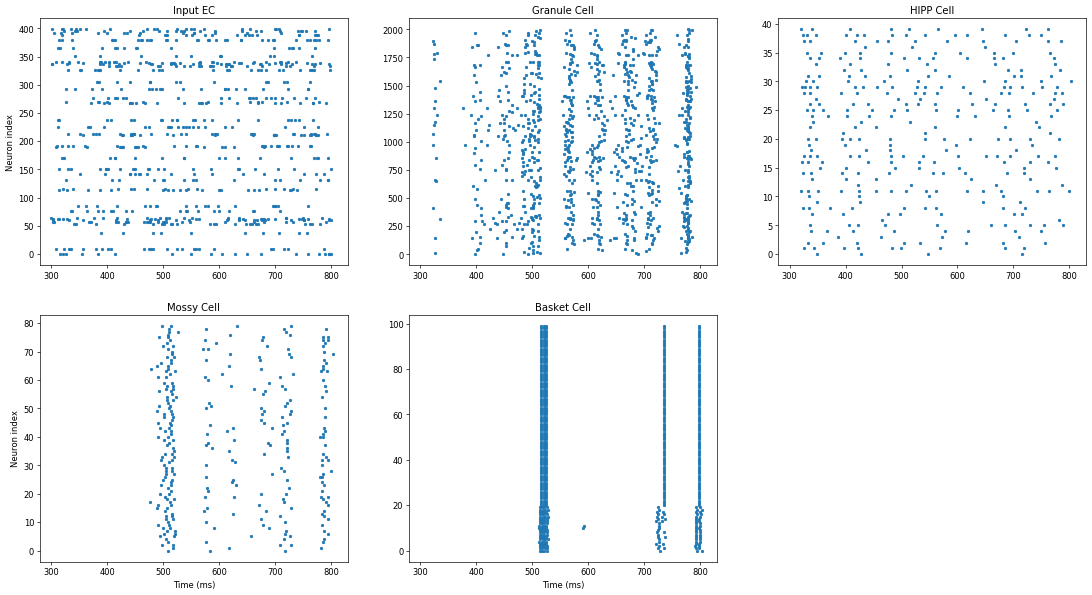

===================overlap:80   Trial:1=========================
Starting simulation at t=0. s for a duration of 0.81 s
0.81 (100%) simulated in 2m 22s

Duration of simulation: 143.76400017738342
Successfully build the network !
[1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 0, 0, 0, 0, 2, 0, 0, 2, 0, 0, 0, 0, 0, 2, 0, 0, 1, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 5, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 3, 0, 1, 0, 0, 3, 0, 0, 0, 1, 0, 0, 2, 0, 3, 3, 1, 6, 0, 0, 0, 2, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 3, 0, 0, 0, 0, 0, 10, 1, 0, 2, 0, 7, 1, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 2, 0, 1, 0, 0, 3, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 5, 0, 4, 0, 1, 6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 3, 0, 2, 0, 0, 2, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 2, 0, 0, 3

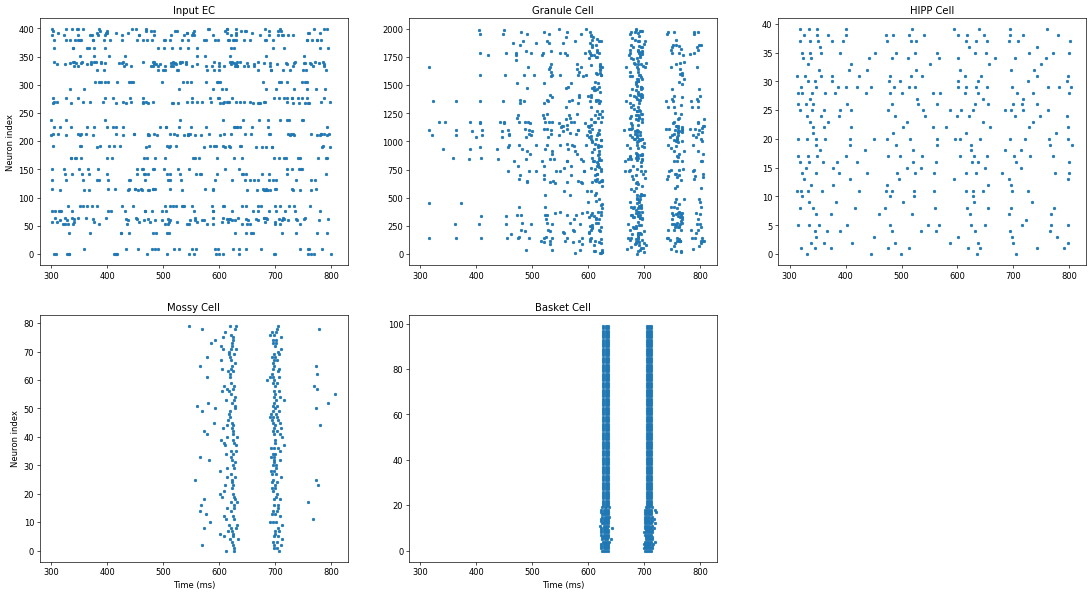

===================overlap:80   Trial:2=========================
Starting simulation at t=0. s for a duration of 0.81 s
0.81 (100%) simulated in 2m 22s

Duration of simulation: 144.1050000190735
Successfully build the network !
[1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 3, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 1, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 2, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 6, 0, 0, 3, 0, 6, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 3, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 1, 0, 1, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 5, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

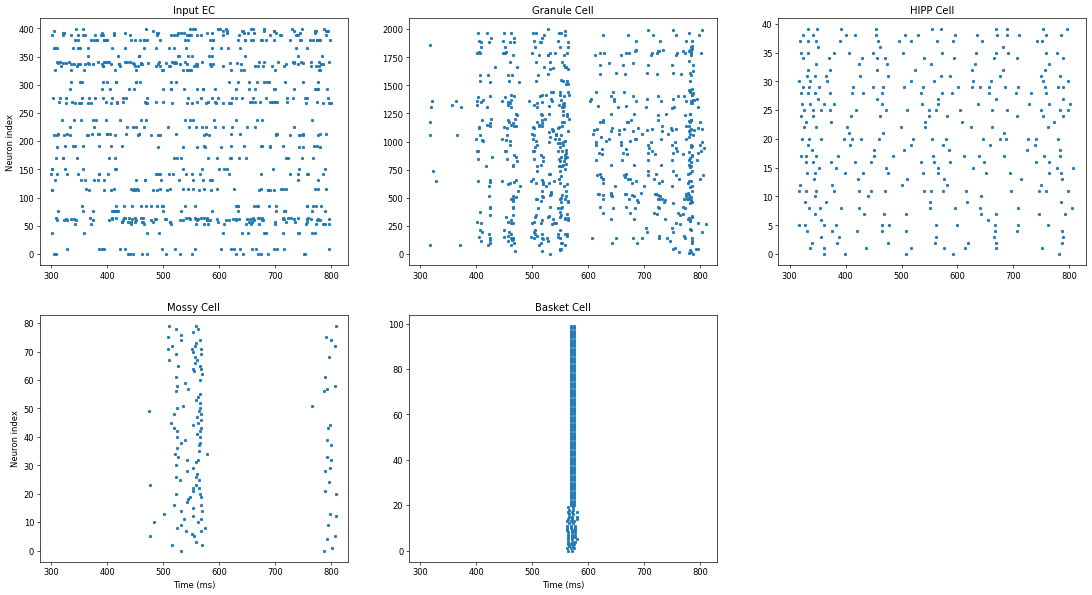

===================overlap:80   Trial:3=========================
Starting simulation at t=0. s for a duration of 0.81 s
0.81 (100%) simulated in 2m 22s

Duration of simulation: 143.7220001220703
Successfully build the network !
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 3, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 2, 10, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 3, 0, 0, 0, 0, 0, 7, 0, 0, 0, 0, 7, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 1,

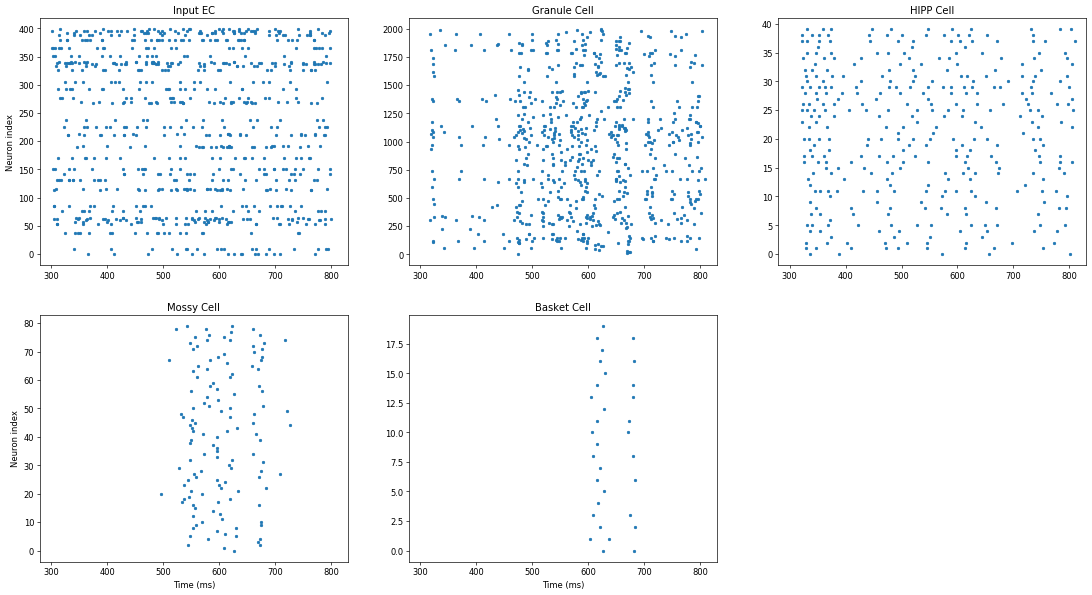

===================overlap:80   Trial:4=========================
Starting simulation at t=0. s for a duration of 0.81 s
0.81 (100%) simulated in 2m 22s

Duration of simulation: 143.54900002479553
Successfully build the network !
[3, 0, 0, 0, 0, 1, 0, 0, 0, 0, 2, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 2, 0, 0, 1, 0, 1, 3, 0, 1, 0, 0, 0, 4, 0, 0, 0, 0, 0, 4, 1, 0, 0, 0, 2, 0, 0, 5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 1, 0, 3, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 5, 0, 0, 0, 0, 1, 0, 0, 0, 0, 3, 0, 0, 0, 3, 1, 1, 7, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 4, 0, 0, 0, 0, 0, 3, 0, 0, 3, 0, 8, 0, 0, 0, 1, 0, 0, 1, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 4, 0, 1, 0, 0, 0, 0, 5, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 5, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 5, 0, 2, 3, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0,

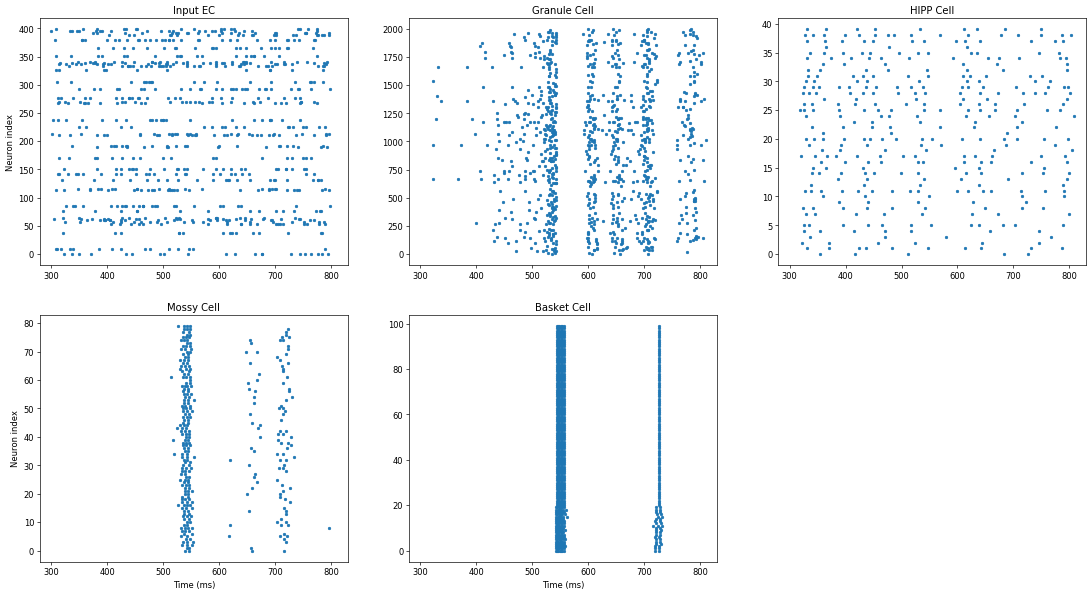

In [31]:
# origin

N_gc_spike_result = []
N_G_S_i_result = []

os_path = < the root path> # "G:\\研究生课程\\origin"
Trial_num = 5  # 试验次数
overlap_list = ['80']  # overlap
for overlap_str in overlap_list:
    for Trial_str in range(Trial_num): 
        print('===================overlap:'+str(overlap_str)+'   Trial:'+str(Trial_str)+'=========================')
        [num_gc_spike, len_G_S, firing_rate, simtime] = DG_with_EC_GC_MC_BC_HIPP(os_path, Trial_str, overlap_str)
        N_gc_spike_result.append(num_gc_spike)
        N_G_S_i_result.append(len_G_S)

In [32]:
print(N_gc_spike_result)
print(N_G_S_i_result)

[409, 400, 273, 251, 413]
[1055, 895, 716, 717, 1021]
